In [1]:
%matplotlib inline

# Main libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Work with sql
import psycopg2 
from sqlalchemy import create_engine, text, inspect
from sqlalchemy.engine import URL

# Add
# !pip install pyarrow
# !pip install fastparquet

In [2]:
# Set folder for files
folder = 'bench_files'
sql_folder = ''

# Establish URL for connection to the database 
url_object = URL.create(
    'postgresql+psycopg2',
    username='postgres',
    password='Ee123456!',
    host='localhost',
    database='Masters:Programing_with_python',
)
engine = create_engine(url_object)

# Set plt style
plt.style.use('ggplot')

# Creating dataset

In [3]:
class SynthDF(pd.DataFrame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    @property
    def _constructor(self):
        return SynthDF
    
    @classmethod
    def create_data(cls, size):
        """
        Create a synthetic DataFrame with random data.

        Parameters
        ----------
        size : int
            Number of rows in the DataFrame.
        """
        df = cls()
        
        # dates
        dates = pd.date_range('2024-01-01', '2024-12-31')
        df['date'] = np.random.choice(dates, size)
        # int data
        df['tournament_id'] = np.arange(size)
        df['team_id'] = np.random.randint(1, 1000, size)
        df['members'] = np.random.randint(1, 10, size)
        # categorical data
        df['location'] = np.random.choice(['Asia', 'Europe', 'Africa', 'America', 'Oceania'], size)
        df['importance'] = np.random.choice(['local', 'minor', 'major'], size)

        # float data
        df['avg_age'] = np.random.randint(100, 500, size) / 10
        df['prize'] = np.random.randint(10000, 10000000, size) / 100
        df['prob'] = np.random.uniform(0, 1, size)
        # bool data
        df['win'] = np.random.choice([True, False], size)
        
        return df

    def dtypes_setter(self):
        """
        Set data types for columns in a synthetic DataFrame.

        - Integers: 'tournament_id' ('int32'), 'team_id' ('int16'), 'members' ('int8').
        - Categorical: 'location', 'importance'.
        - Floats: 'avg_age' ('float16'), 'prize' ('float32'), 'prob' ('float32').
        """

        # int data
        self['tournament_id'] = self['tournament_id'].astype('int32')
        self['team_id'] = self['team_id'].astype('int16')
        self['members'] = self['members'].astype('int8')

        # categorical data
        self['location'] = self['location'].astype('category')
        self['importance'] = self['importance'].astype('category')

        # float data
        self['avg_age'] = self['avg_age'] .astype('float32')
        self['prize'] = self['prize'].astype('float32')
        self['prob'] = self['prob'].astype('float32')

    def benchmark(self, f_name, write_method, read_method, kwargs_write={}, kwargs_read={}):
        """
        Benchmark the performance and space requirements of writing and reading a DataFrame.

        Parameters
        ----------
        f_name : str
            The name of the file to be used for benchmarking.
        write_method : callable
            The method used to write the DataFrame to a file.
        read_method : callable
            The method used to read the DataFrame from a file.
        kwargs_write : dict, optional
            Additional keyword arguments for the write method.
        kwargs_read : dict, optional
            Additional keyword arguments for the read method.

        Returns
        -------
        dict
            A dictionary containing benchmark results.
            - 'format': The file format extension.
            - 'df_size': The size identifier of the DataFrame.
            - 'write': Timing information for the write operation.
            - 'read': Timing information for the read operation.
            - 'size': The size of the file on disk in bytes.
            - 'metadata': Whether metadata (data types) is preserved in the read operation.
        """
        # Set path to file 
        file = os.path.join(folder, f_name)

        # Bench write time
        write = %timeit -o -n 3 -r 3 write_method(self, file, **kwargs_write)

        # Bench read time
        read = %timeit -o -n 3 -r 3 read_method(file, **kwargs_read)

        # Bench size of file
        if write_method == pd.DataFrame.to_sql:
            # Get size of SQL db
            with engine.connect() as conn:
                query = text(f"SELECT pg_total_relation_size('{file}')")
                space = conn.execute(query).scalar()
                f_name += '.sql'
        else:
            # Get size of file 
            space = os.path.getsize(file)
        print(f'{space} bytes (required space)')

        # Metadata
        new_df = read_method(file, **kwargs_read)
        ziped = zip(new_df.dtypes, self.dtypes) 
        saved_metadata = [type1.base == type2.base for type1, type2 in ziped]
        print('metadata is saved' if all(saved_metadata) else 'metadata is NOT saved')

        result = {
            'format': f_name.split('.')[-1],
            'df_size': f_name.split('_')[0],
            'write': write.average,
            'read': read.average,
            'size': space,
            'metadata': all(saved_metadata)
        }

        return result

In [4]:
# Data synthesis
df_small = SynthDF.create_data(10000)
df_medium = SynthDF.create_data(100000)
df_large = SynthDF.create_data(1000000)

# Change dtypes
df_small.dtypes_setter()
df_medium.dtypes_setter()
df_large.dtypes_setter()

In [6]:
# Init df for result
result = pd.DataFrame(columns=['format','df_size','write', 'read', 'size', 'metadata'])

In [6]:
df_small.dtypes

date             datetime64[ns]
tournament_id             int32
team_id                   int16
members                    int8
location               category
importance             category
avg_age                 float32
prize                   float32
prob                    float32
win                        bool
dtype: object

# CSV

In [7]:
temp = df_small.benchmark(
    f_name='s_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

73 ms ± 3.5 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
15 ms ± 1.24 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
657030 bytes (required space)
metadata is NOT saved


In [8]:
temp = df_medium.benchmark(
    f_name='m_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

588 ms ± 13.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
124 ms ± 5.44 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
6670593 bytes (required space)
metadata is NOT saved


In [9]:
temp = df_large.benchmark(
    f_name='l_csv.csv', 
    write_method=pd.DataFrame.to_csv, 
    read_method=pd.read_csv,
    kwargs_write={'index': False}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

5.81 s ± 18.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
1.05 s ± 5.28 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
67701348 bytes (required space)
metadata is NOT saved


# JSON

In [10]:
temp = df_small.benchmark(
    f_name='s_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

16 ms ± 2.35 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
66.8 ms ± 4.23 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
1553345 bytes (required space)
metadata is NOT saved


In [11]:
temp = df_medium.benchmark(
    f_name='m_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

147 ms ± 757 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
790 ms ± 15.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
16627670 bytes (required space)
metadata is NOT saved


In [12]:
temp = df_large.benchmark(
    f_name='l_json.json', 
    write_method=pd.DataFrame.to_json, 
    read_method=pd.read_json,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

1.68 s ± 6.58 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
10.6 s ± 32 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
177280574 bytes (required space)
metadata is NOT saved


# SQL?

In [13]:
temp = df_small.benchmark(
    f_name='s_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

589 ms ± 24.6 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
86.1 ms ± 1.86 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
802816 bytes (required space)
metadata is NOT saved


In [14]:
temp = df_medium.benchmark(
    f_name='m_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

5.47 s ± 31.1 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
569 ms ± 8.99 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
7692288 bytes (required space)
metadata is NOT saved


In [15]:
temp = df_large.benchmark(
    f_name='l_sql', # This case sql db name
    write_method=pd.DataFrame.to_sql, 
    read_method=pd.read_sql_table,
    kwargs_write={'con':engine, 'if_exists':'replace', 'index':False},
    kwargs_read={'con':engine}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

55 s ± 101 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
5.44 s ± 3.88 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
76619776 bytes (required space)
metadata is NOT saved


# Pickle

In [16]:
temp = df_small.benchmark(
    f_name='s_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

1.26 ms ± 62.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
2.22 ms ± 1.24 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
301977 bytes (required space)
metadata is saved


In [17]:
temp = df_medium.benchmark(
    f_name='m_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

3.04 ms ± 19.1 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
3.28 ms ± 1.82 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
3002062 bytes (required space)
metadata is saved


In [18]:
temp = df_large.benchmark(
    f_name='l_pickle.pickle', 
    write_method=pd.DataFrame.to_pickle, 
    read_method=pd.read_pickle,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

16.6 ms ± 1.9 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
17.8 ms ± 1.31 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
30002062 bytes (required space)
metadata is saved


# Feather
`
!pip istall pyarrow
`

In [19]:
temp = df_small.benchmark(
    f_name='s_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

6.51 ms ± 1.03 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
4.72 ms ± 1.55 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
229122 bytes (required space)
metadata is saved


In [20]:
temp = df_medium.benchmark(
    f_name='m_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

8.37 ms ± 741 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
12.3 ms ± 6.55 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
2188690 bytes (required space)
metadata is saved


In [21]:
temp = df_large.benchmark(
    f_name='l_feather.feather', 
    write_method=pd.DataFrame.to_feather, 
    read_method=pd.read_feather,
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

41.2 ms ± 2.97 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
50.9 ms ± 11.3 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
21825146 bytes (required space)
metadata is saved


# Parquet
`
!pip istall fastparquet
`

In [22]:
temp = df_small.benchmark(
    f_name='s_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

18.3 ms ± 10.7 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
5.92 ms ± 1.75 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
235728 bytes (required space)
metadata is saved


In [23]:
temp = df_medium.benchmark(
    f_name='m_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

23.4 ms ± 1.52 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
9.77 ms ± 537 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
2311834 bytes (required space)
metadata is saved


In [24]:
temp = df_large.benchmark(
    f_name='l_parquet.parquet', 
    write_method=pd.DataFrame.to_parquet, 
    read_method=pd.read_parquet,
    kwargs_write={'engine':'fastparquet'},
    kwargs_read={'engine':'fastparquet'}
)
result = pd.concat([result, pd.DataFrame.from_dict(temp, orient='index').transpose()], ignore_index=True)

146 ms ± 3.54 ms per loop (mean ± std. dev. of 3 runs, 3 loops each)
65.5 ms ± 315 µs per loop (mean ± std. dev. of 3 runs, 3 loops each)
23055911 bytes (required space)
metadata is saved


# Show results

In [25]:
result['size'] /= 1_000_000 # Convert to MB
result

,format,df_size,write,read,size,metadata
0,csv,s,0.072956,0.015033,0.65703,False
1,csv,m,0.588109,0.124094,6.670593,False
2,csv,l,5.814575,1.052236,67.701348,False
3,json,s,0.015993,0.066772,1.553345,False
4,json,m,0.146555,0.789875,16.62767,False
5,json,l,1.676479,10.628014,177.280574,False
6,sql,s,0.588661,0.08609,0.802816,False
7,sql,m,5.472238,0.568677,7.692288,False
8,sql,l,54.990787,5.443761,76.619776,False
9,pickle,s,0.001263,0.002216,0.301977,True


# Group data

In [26]:
# Group DF by 'format' and 'df_size'
grouped = result.groupby(['format', 'df_size']).mean().unstack()
grouped

write                           read                      \
df_size          l         m         s          l         m         s   
format                                                                  
csv       5.814575  0.588109  0.072956   1.052236  0.124094  0.015033   
feather   0.041182  0.008374  0.006508   0.050914  0.012253  0.004721   
json      1.676479  0.146555  0.015993  10.628014  0.789875  0.066772   
parquet   0.146346  0.023446  0.018345    0.06547  0.009773  0.005923   
pickle    0.016606  0.003041  0.001263     0.0178  0.003275  0.002216   
sql      54.990787  5.472238  0.588661   5.443761  0.568677   0.08609   

               size                     metadata            
df_size           l         m         s        l    m    s  
format                                                      
csv       67.701348  6.670593   0.65703      0.0  0.0  0.0  
feather   21.825146   2.18869  0.229122      1.0  1.0  1.0  
json     177.280574  16.62767  1.553345      0.0  0.0  0.0  
parquet   23.055911  2.311834  0.235728      1.0  1.0  1.0  
pickle    30.002062  3.002062  0.301977      1.0  1.0  1.0  
sql       76.619776  7.692288  0.802816      0.0  0.0  0.0

# Draw graphs

In [27]:
def plot_data(df, title='', y_label=''):
    ax = df.plot(kind='bar', figsize=(12, 6), width=0.8, logy=True)
    for p in ax.patches:
        ax.annotate(str(round(p.get_height(), 4)), 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', 
                    va='center', 
                    xytext=(0, 30), 
                    textcoords='offset points',
                    rotation=90
                   )

    plt.title(title)
    plt.xlabel('File format')
    plt.xticks(rotation=0)
    plt.ylabel(y_label)
    plt.ylim(top=df.max().max()*10)

## read

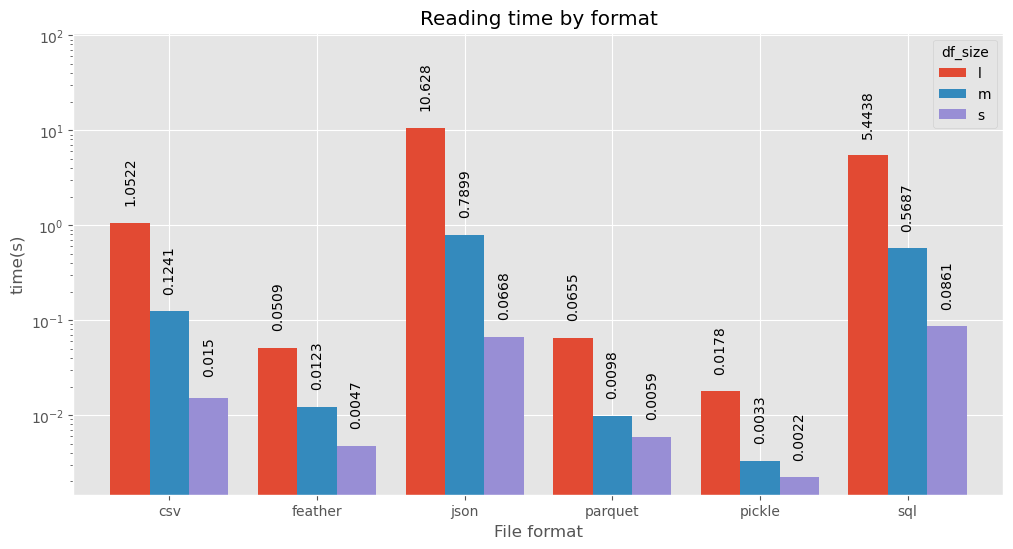

In [28]:
plot_data(grouped['read'], 'Reading time by format', 'time(s)')

## write

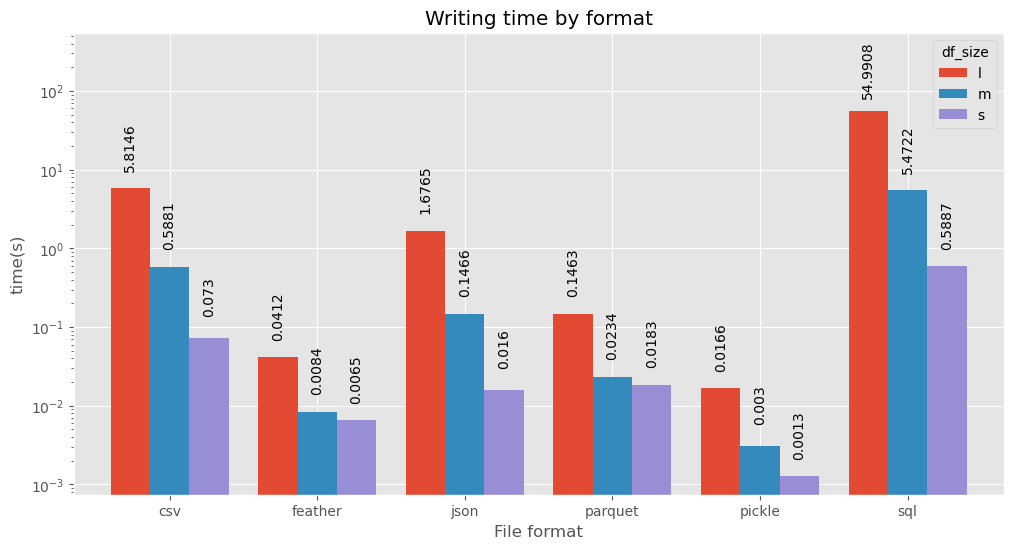

In [30]:
plot_data(grouped['write'], 'Writing time by format', 'time(s)')

## size

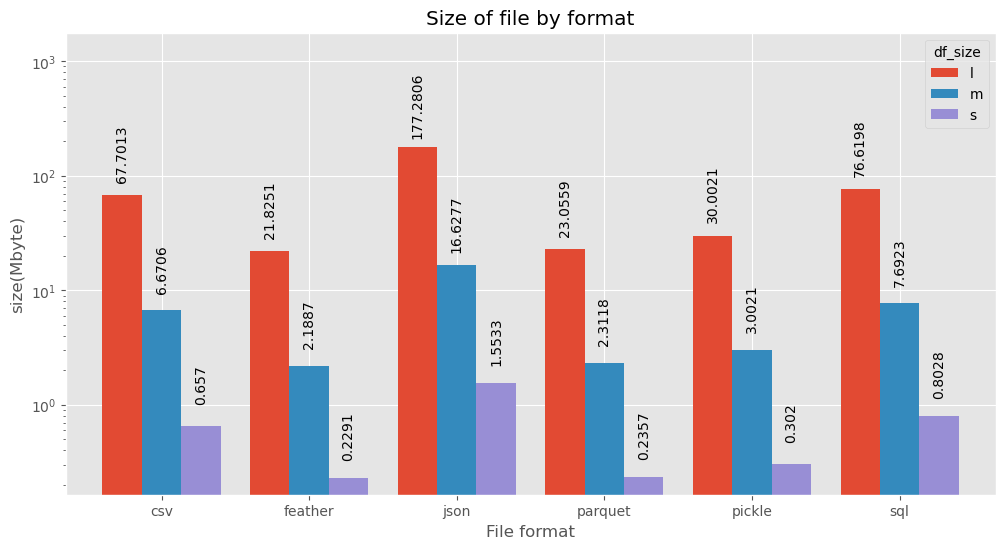

In [31]:
plot_data(grouped['size'], 'Size of file by format', 'size(Mbyte)')